In [134]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from copy import deepcopy
%matplotlib inline

In [2]:
plt.style.use("fivethirtyeight")

Import datafile with Longitude and Latitude locations of 30 United States National parks.

In [3]:
parks = pd.read_csv("parks.csv")
parks.head()

,Name,Longitude,Latitude
0,Acadia,-68.21,44.35
1,Arches,-109.57,38.68
2,Badlands,-102.50,43.75
3,Big Bend,-103.25,29.25
4,Black Canyon,-107.72,38.57


In [4]:
names = parks["Name"].values
names

array(['Acadia', 'Arches', 'Badlands', 'Big Bend', 'Black Canyon ',
       'Bryce Canyon', 'Canyonlands', 'Crater Lake', 'Cuyahoga Valley',
       'Everglades', 'Glacier', 'Grand Canyon', 'Grand Teton',
       'Great Sand Dunes', 'Great Smoky Mountains', 'Hot Springs',
       'Isle Royale', 'Joshua Tree', 'Lassen Volcanic', 'Mesa Verde',
       'Mount Rainier', 'North Cascades', 'Olympic', 'Pinnacles',
       'Rocky Mountain', 'Sequoia', 'Voyageurs', 'Yellowstone', 'Yosemite',
       'Zion'], dtype=object)

Construct a distance matrix of simple Euclidean distance between the national parks utilizing simplication of longitude and latitude to represent X and Y coordinates.

In [13]:
dists = np.zeros((30, 30))
for i in range(30):
    for j in range(30):
        park1 = parks.iloc[i, 1:]
        park2 = parks.iloc[j, 1:]
        long1 = park1[0]
        lat1 = park1[1]
        long2 = park2[0]
        lat2 = park2[1]
        dists[i, j] = np.sqrt((long1 - long2)**2 + (lat1 - lat2)**2)

Construct a path that travels to the national parks in alphabetical order.

In [16]:
alphabetical = range(30)
alphabetical.append(0)

Function to calculate the distance of a route with a given distance matrix.

In [17]:
def path_dist(distances, route):
    dist = 0.0
    for i in range(30):
        start = route[i]
        end = route[i + 1]
        dist += distances[start, end]
    dist += distances[route[-1], route[0]]
    return dist
print path_dist(dists, alphabetical)

491.918171446


Use a Markov Chain Monte Carlo method to explore the space of traveling salesman tours. The algorithm begins by starting with a random permuation of the parks. At each iteration, 2 adjacent parks in the path are selected and a route is proposed by switching their order. If the proposed route has a lower total distance than the original route, the proposed route is accepted. Otherwise, if T > 0, with probability exp(-delta distance/T) the current route is updated to the proposed route where delta distance is the increase in total distance. This process is repeated MAXITER times.

In [148]:
def trial(distances, maxiters, T):
    start = random.randint(0, 29) #create initial permuation route.
    route = [start]
    parks = set(range(30))
    rest_parks = list(parks.difference(route))
    random.shuffle(rest_parks)
    route.extend(rest_parks)
    route.append(start)
    best = route
    dist_best = path_dist(distances, best)
    iter_dists = []
    for i in xrange(maxiters):
        old_dist = path_dist(distances, route)
        rand_index = random.choice(range(30)) #choose 2 adjacent parks randomly
        park1 = route[rand_index]
        park2 = route[rand_index + 1]
        route_new = deepcopy(route)
        if rand_index == 0:   #switch positions of two randomly chosen parks
            route_new[-1] = park2
        elif rand_index == 29:
            route_new[0] = park1
        route_new[rand_index] = park2
        route_new[rand_index + 1] = park1
        new_dist = path_dist(distances, route_new)
        delta_dist = new_dist - old_dist #find change in route distance
        if (delta_dist < 0) or (T > 0 and random.uniform(0.0, 1.0) < np.exp(-delta_dist / T)):
            route = route_new
        route_dist = path_dist(distances, route)
        iter_dists.append(route_dist)
        if  route_dist < dist_best: #see if new route is better than the best route seen so far
            best = route
            dist_best = route_dist
    return best, dist_best, iter_dists

4 different settings of T are used with T = 0, 1, 10, and 100. With T = 0, a proposed route is accepted only if it decreases the route distance. As T becomes larger, the probability of accepting a proposed route that increases the distance from the current route increases. The intermediate setting with T = 10 appears to achieve the best final results.

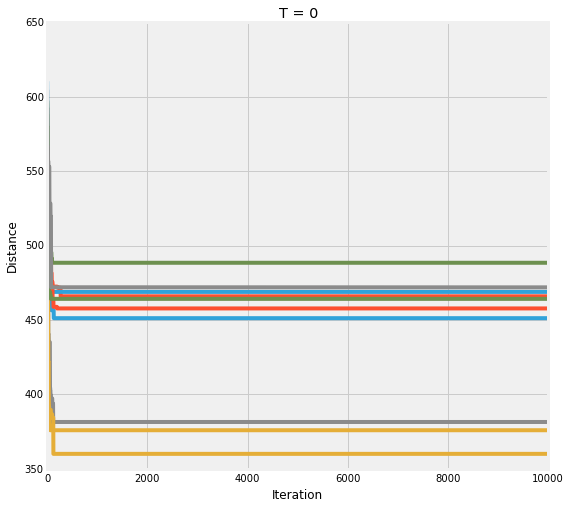

In [136]:
plt.figure(figsize=(8, 8))
for i in range(10):
    best_route, dist_best, iter_dists = trial(dists, 10000, 0)
    plt.plot(range(10000), iter_dists);
plt.xlabel("Iteration");
plt.ylabel("Distance");
plt.title("T = 0");

With T = 0, the solution is equivalent to the greedy algorithm that only accepts changes that improve on the previous step and it is likely to become stuck in a local optimum. The introduction of a positive T allows for the algorithm to move away from local optima and search more potential solutions.

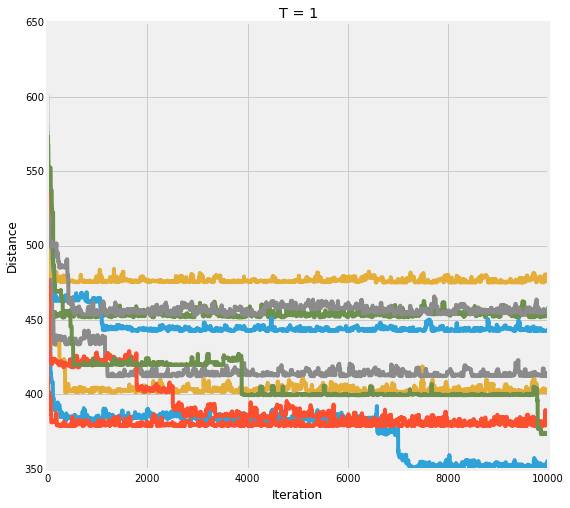

In [140]:
plt.figure(figsize=(8, 8))
for i in range(10):
    best_route, dist_best, iter_dists = trial(dists, 10000, 1)
    plt.plot(range(10000), iter_dists);
plt.xlabel("Iteration");
plt.ylabel("Distance");
plt.title("T = 1");

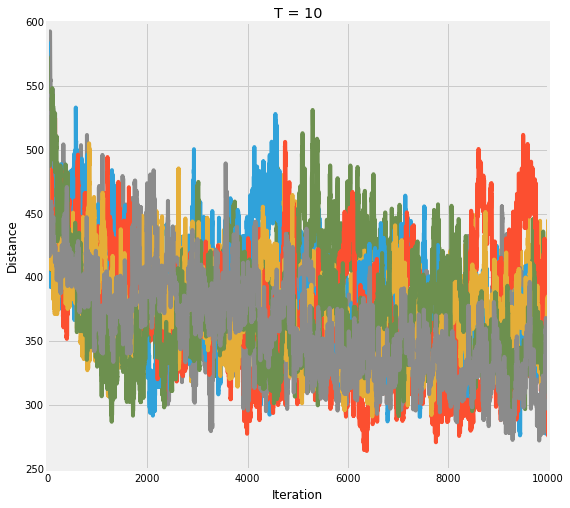

In [145]:
plt.figure(figsize=(8, 8))
for i in range(10):
    best_route, dist_best, iter_dists = trial(dists, 10000, 10)
    plt.plot(range(10000), iter_dists);
plt.xlabel("Iteration");
plt.ylabel("Distance");
plt.title("T = 10");

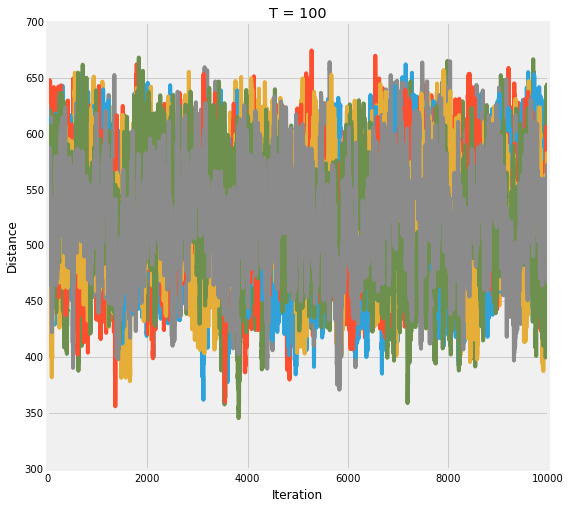

In [186]:
plt.figure(figsize=(8, 8))
for i in range(10):
    best_route, dist_best, iter_dists = trial(dists, 10000, 100)
    plt.plot(range(10000), iter_dists);
plt.xlabel("Iteration");
plt.ylabel("Distance");
plt.title("T = 100");

Modify the MCMC algorithm such that in each iteration, two parks are selected at random (not necessarily successive parks) and propose the route obtained by switching them.  Also optionally the temperature parameter T can be multiplied by a factor and decreased on each iteration.

In [200]:
def trial2(distances, maxiters, T, factor=1.0):
    start = random.randint(0, 29) #create initial permuation route.
    route = [start]
    parks = set(range(30))
    rest_parks = list(parks.difference(route))
    random.shuffle(rest_parks)
    route.extend(rest_parks)
    route.append(start)
    best = route
    dist_best = path_dist(distances, best)
    iter_dists = []
    for i in xrange(maxiters):
        old_dist = path_dist(distances, route)
        rand_indices = sorted(random.sample(xrange(30), 2)) #choose 2 parks randomly
        park1 = route[rand_indices[0]]
        park2 = route[rand_indices[1]]
        route_new = deepcopy(route)
        route_new[rand_indices[0]] = park2
        route_new[rand_indices[1]] = park1
        route_new[-1] = route_new[0]
        new_dist = path_dist(distances, route_new)
        delta_dist = new_dist - old_dist #find change in route distance
        if (delta_dist < 0) or (T > 0 and random.uniform(0.0, 1.0) < np.exp(-delta_dist / T)):
            route = route_new
        T *= factor
        route_dist = path_dist(distances, route)
        iter_dists.append(route_dist)
        if  route_dist < dist_best: #see if new route is better than the best route seen so far
            best = route
            dist_best = route_dist
    return best, dist_best, iter_dists

With the change in how the proposed route is made, more different proposal routes are possible as now changes are not restricted to swapping adjacent parks. With the same number of iterations and T parameter, this modified algorithm is able to find better solutions as more possibilities can be proposed more rapidly.

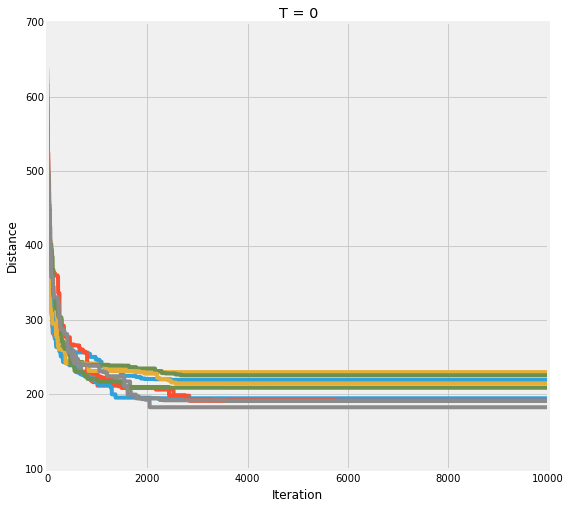

In [196]:
plt.figure(figsize=(8, 8))
for i in range(10):
    best_route, dist_best, iter_dists = trial2(dists, 10000, 0)
    plt.plot(range(10000), iter_dists);
plt.xlabel("Iteration");
plt.ylabel("Distance");
plt.title("T = 0");

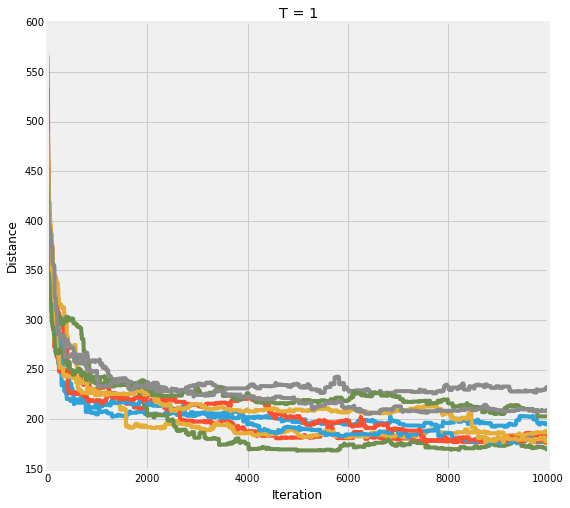

In [197]:
plt.figure(figsize=(8, 8))
for i in range(10):
    best_route, dist_best, iter_dists = trial2(dists, 10000, 1)
    plt.plot(range(10000), iter_dists);
plt.xlabel("Iteration");
plt.ylabel("Distance");
plt.title("T = 1");

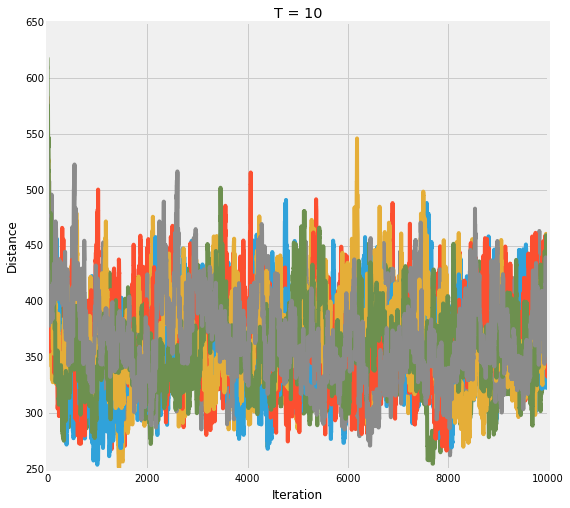

In [198]:
plt.figure(figsize=(8, 8))
for i in range(10):
    best_route, dist_best, iter_dists = trial2(dists, 10000, 10)
    plt.plot(range(10000), iter_dists);
plt.xlabel("Iteration");
plt.ylabel("Distance");
plt.title("T = 10");

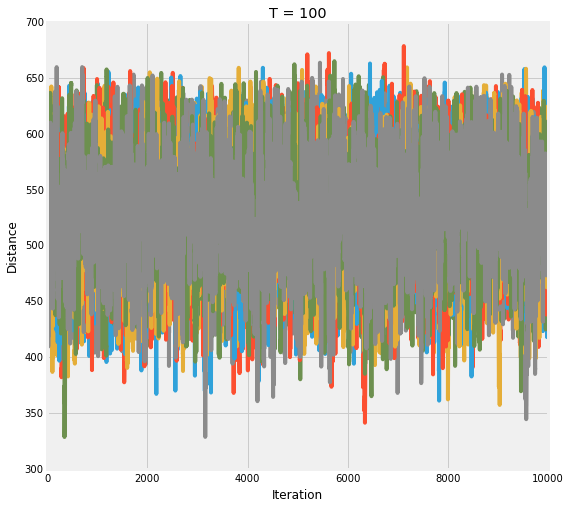

In [199]:
plt.figure(figsize=(8, 8))
for i in range(10):
    best_route, dist_best, iter_dists = trial2(dists, 10000, 100)
    plt.plot(range(10000), iter_dists);
plt.xlabel("Iteration");
plt.ylabel("Distance");
plt.title("T = 100");

This plot uses T = 100 but also adds a multiplicative factor = 0.9995 that gradually decreases the probability of accepting a worse proposed route. From the plot you can see that the variability decreases and the proposed route converges to a solution.

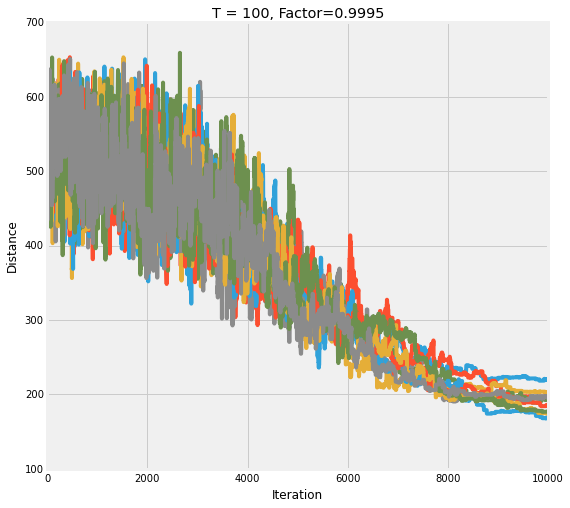

In [202]:
plt.figure(figsize=(8, 8))
for i in range(10):
    best_route, dist_best, iter_dists = trial2(dists, 10000, 100, factor=0.9995)
    plt.plot(range(10000), iter_dists);
plt.xlabel("Iteration");
plt.ylabel("Distance");
plt.title("T = 100, Factor=0.9995");